In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances

Part 1: plot the theoretical dependency between n_components_min and n_samples

In [2]:
# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)  # Maximum distortion rate as defined by the Johnson-Lindenstrauss lemma
colors = plt.cm.Blues(np.linspace(0.3,1.0,len(eps_range)))
eps_range

array([0.1   , 0.3225, 0.545 , 0.7675, 0.99  ])

In [3]:
# range of number of samples (observation) to embed
n_samples_range = np.logspace(1,9,9)
n_samples_range

array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09])

min_n_components:
 [ 1973  3947  5920  7894  9868 11841 13815 15789 17762]
min_n_components:
 [ 225  451  676  902 1128 1353 1579 1804 2030]
min_n_components:
 [ 97 194 292 389 487 584 681 779 876]
min_n_components:
 [ 64 128 192 256 320 384 448 512 576]
min_n_components:
 [ 55 110 165 221 276 331 386 442 497]


Text(0.5,1,'Johnson-Lindenstrauss bounds:\nn_samples vs n_components')

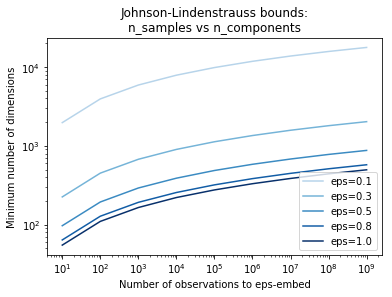

In [4]:
plt.figure()
for eps,color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components,color=color)
    print("min_n_components:\n",min_n_components)
plt.legend(["eps=%0.1f" % eps for eps in eps_range], loc='lower right')
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")

In [5]:
# range of admissible distortions
eps_range = np.linspace(0.01,0.99,100)

# range of number of samples (observation) to embed
n_samples_range = np.logspace(2,6,5)
colors = plt.cm.Blues(np.linspace(0.3,1.0,len(n_samples_range)))
n_samples_range

array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])

Text(0.5,1,'Johnson-Lindenstrauss bounds:\nn_components vs eps')

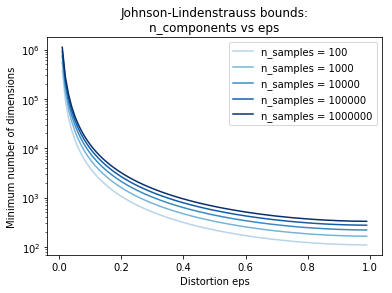

In [6]:
plt.figure()
for n_samples,color in zip(n_samples_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples,eps=eps_range)
    plt.semilogy(eps_range, min_n_components,color=color)
plt.legend(["n_samples = %d" % n for n in n_samples_range], loc='upper right')
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")

Part 2: perform sparse random projection of soe doggits images which are quite low dimensional and dense or documents of the 20 newsgroups dataset which is both high dimensional and sparse

In [7]:
if '--twenty-newsgroups' in sys.argv:
    # Need an internet connection hence not enable by default
    data = fetch_20newsgroups_vectorized().data[:500]
else:
    data = load_digits().data[:500]

In [8]:
n_samples, n_features = data.shape
print("Enbedding %d samples with dim %d using various random projections"
      % (n_samples,n_features))

Enbedding 500 samples with dim 64 using various random projections


In [9]:
n_components_range = np.array([300,1000,10000])
dists = euclidean_distances(data,squared=True).ravel()
dists.shape

(250000,)

In [10]:
# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]
dists

array([3547., 2930., 2263., ..., 3668., 3335., 3271.])

Projected 500 samples from 64 to 300 in 0.007s
Random matrix with size: 0.028sMB


C:\Users\sunqu\Anaconda3\lib\site-packages\sklearn\random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (64 < 300).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


Mean distances rate: 0.97 (0.08)
Projected 500 samples from 64 to 1000 in 0.041s
Random matrix with size: 0.095sMB


C:\Users\sunqu\Anaconda3\lib\site-packages\sklearn\random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (64 < 1000).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


Mean distances rate: 0.96 (0.04)


C:\Users\sunqu\Anaconda3\lib\site-packages\sklearn\random_projection.py:378: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (64 < 10000).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


Projected 500 samples from 64 to 10000 in 0.345s
Random matrix with size: 0.964sMB
Mean distances rate: 1.01 (0.01)


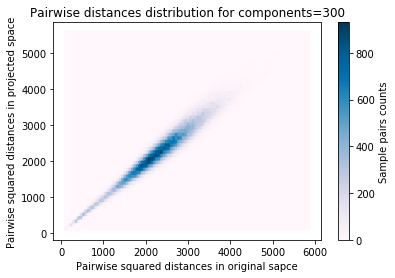

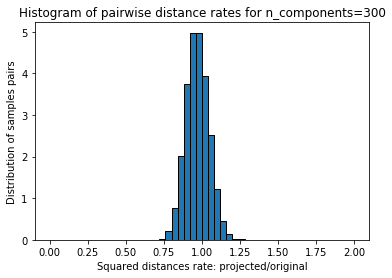

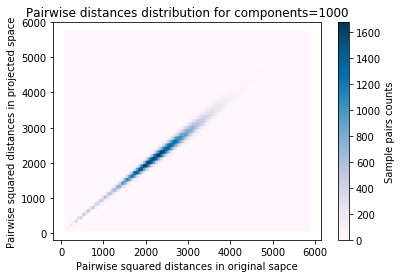

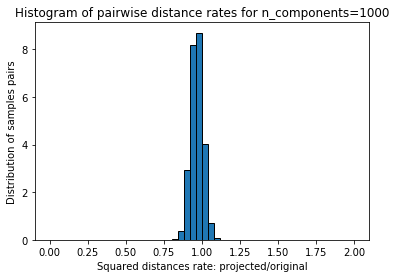

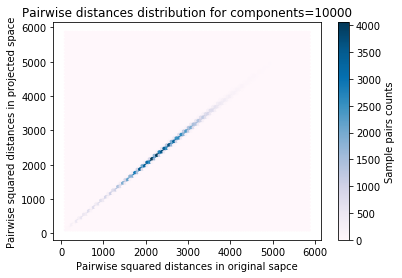

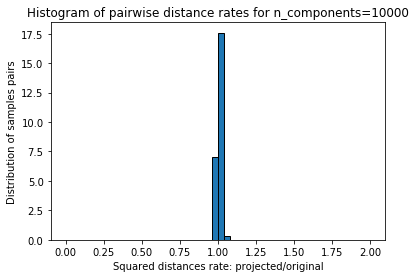

In [11]:
for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print("Projected %d samples from %d to %d in %0.3fs" % (n_samples, n_features, n_components,time() - t0))
    if  hasattr(rp,'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fsMB" % (n_bytes/1e6))
        
    projected_dists = euclidean_distances(projected_data, squared=True).ravel()[nonzero]
    
    plt.figure()
    plt.hexbin(dists,projected_dists,gridsize=100,cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original sapce")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for components=%d" % n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')
    
    rates = projected_dists/dists
    print("Mean distances rate: %0.2f (%0.2f)" % (np.mean(rates),np.std(rates)))
    
    plt.figure()
    plt.hist(rates, bins=50, normed=True, range=(0.,2.),edgecolor='k')
    plt.xlabel("Squared distances rate: projected/original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" % n_components)
    
plt.show()